<a href="https://colab.research.google.com/github/riccardomarin/SpectralShapeAnalysis/blob/master/Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ONLY FOR COLAB
# Not required in Binder

!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local python=3.6 ujson

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

import ujson
print(ujson.dumps({1:2}))

!conda install -c conda-forge igl
!conda install -c conda-forge meshplot

--2020-07-26 21:00:32--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   111MB/s    in 0.5s    

2020-07-26 21:00:32 (111 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6

In [5]:
import igl
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import meshplot
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix
import os 
from sklearn.cluster import KMeans

In [6]:
def plot_pair(v1, v2, f1, f2, c1, c2, color_ops = {}):
    # Compute a scale factor
    M1 = igl.massmatrix(v1, f1, igl.MASSMATRIX_TYPE_VORONOI)
    M2 = igl.massmatrix(v2, f2, igl.MASSMATRIX_TYPE_VORONOI)
    scale_factor = np.sqrt(np.sum(M2)/np.sum(M1))

    # Align the shapes
    v2 = v2 - np.mean(v2,axis=0)
    v1_align = v1 * scale_factor + np.mean(v1,axis=0) + [0.7,-0.7,0.0]

    # Merge the models
    v_all = np.vstack((v1_align, v2))
    f_all = np.vstack((f1, f2 + np.max(f1)+1))
    c_all = np.vstack((c1, c2))
    
    plot(v_all, f_all, c_all, shading = color_ops)

# WKS

We will use the Wave Kernel Signature (WKS) descriptor to do the matching. Recall the formula:

$K_E(x,x) = \sum\limits_{l=1}^{\infty}e^{- \frac{(log(E) - log(\lambda_l))^2}{2\sigma^2}} \phi_l(x)^2 $

Where:
- $sigma = 7 \delta$
- $delta =  (e_{max} - e{min})/ M$
- $e_{max} = log(E_N) - 2\sigma$
- $e_{min} = log(E_1) + 2\sigma$
- $E_N$ is the max eigenvalue in absolute value
- $E_1$ is the min non-zero eigenvalue in absolute value
- $M$ is the number of WKS scales

The tasks are:
- Read the meshes, compute the LBO eigenvectors
- Define the WKS computation
- Visualize the WKS scales on meshes
- Perform the matching using WKS (Nearest-Neighbor in the descriptor space)
- Visualize the matching (and compute the error)

Are the descriptors coherent among the shapes, for different descriptor scales? Is the matching good? We can change the number of descriptors: does it impact the matching?

In [9]:
v_src, f_src = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_089.off"))


L_src = igl.cotmatrix(v_src, f_src)
M_src = igl.massmatrix(v_src, f_src, igl.MASSMATRIX_TYPE_VORONOI)

evals_src, evecs_src = eigs(L_src,k=100,M=M_src,sigma=0)
evecs_src = evecs_src.astype(np.float32)

v_tar, f_tar = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_089.off"))

L_tar = igl.cotmatrix(v_tar, f_tar)
M_tar = igl.massmatrix(v_tar, f_tar, igl.MASSMATRIX_TYPE_VORONOI)

evals_tar, evecs_tar = eigs(L_tar,k=100,M=M_tar,sigma=0)
evecs_tar = evecs_tar.astype(np.float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [10]:
def WKS(vertices, Lambda, Phi, Area, wks_size = 100):
    import numpy as np

    n_evecs = Phi.shape[1]
    absoluteEigenvalues = np.abs(Lambda)
    emin = np.log(absoluteEigenvalues[1])
    emax = np.log(absoluteEigenvalues[len(absoluteEigenvalues) - 1])
    
    D = np.matmul(Phi.T, Area.__matmul__(Phi**2))

    s = 7 * (emax - emin) / wks_size
    
    emin = emin + 2 * s
    emax = emax - 2 * s
    es = np.linspace(emin, emax, wks_size)

    T = np.exp(-np.square(
        np.tile(np.reshape(np.log(absoluteEigenvalues), (n_evecs, 1)), (1, wks_size)) - np.tile(es.T, (n_evecs, 1))) / (
                       2 * np.square(s)))
    WKS = np.matmul(D,T)
    WKS = np.dot(Phi, WKS)

    return np.asarray(WKS)

In [11]:
D_src = WKS(v_src, evals_src, evecs_src, M_src, wks_size = 200)
D_tar = WKS(v_tar, evals_tar, evecs_tar, M_tar, wks_size = 200)

In [12]:
i = 199
plot_pair(v_src, v_tar, f_src, f_tar, D_src[:,i:i+1], D_tar[:,i:i+1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4063018…

In [13]:
import scipy
treesearch = scipy.spatial.cKDTree(D_src)
p2p = treesearch.query(D_tar, k=1)[1]

In [ ]:
funz_ = (v_src - np.min(v_src,0))/np.tile((np.max(v_src,0)-np.min(v_src,0)),(np.size(v_src,0),1));
colors = np.cos(funz_);
funz = (colors-np.min(colors))/(np.max(colors) - np.min(colors));
funz2 = funz[p2p]
funz2

In [ ]:
# subplot(v_src, f_src, funz,s=[1,2,0])
# subplot(v_tar, f_tar, funz2,s=[1,2,1])

plot_pair(v_src, v_tar, f_src, f_tar, funz,funz2)

In [ ]:
def my_WKS(evals, evecs, wks_size = 100):
    abs_evals = np.abs(evals)
    n_evecs = evecs.shape[1]
    
    emin = np.log(abs_evals[1])
    emax = np.log(np.max(abs_evals))
    sigma = 7 * (emax - emin) / wks_size
    
    emin = emin + 2 * sigma
    emax = emax - 2 * sigma
    
    es = np.linspace(emin, emax, wks_size)
    
    for i in np.arange(1, n_evecs):
        squared_evecs = evecs**2
        exponential = np.square(np.exp(es[i]  - np.log(es[i])))/(2 * sigma)
        
    return exponential
    
e = my_WKS(evals_src, evecs_src, 100)
e

# Functional Maps

Here we will use the Functional Maps framework. Given some descriptor $D$ on the first shape and $F$ on the second, we will compute our map $C$ such that: \\
$ d = (\phi_{src}^{T} A_{src} D)^T $ \\
$ f = (\phi_{tar}^{T} A_{tar} F)^T $ \\
$ d C = f $ \\
$ C = d^{-1} f $

In [39]:
d = (np.matmul(evecs_src.T, np.matmul( M_src.todense() , D_src))).T
f = (np.matmul(evecs_tar.T, np.matmul( M_tar.todense() , D_tar))).T
C = np.linalg.pinv(d) * f

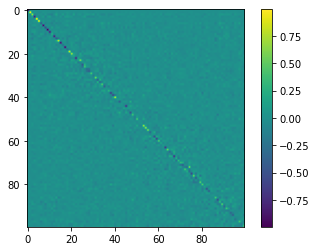

(100, 6890)

In [40]:
import matplotlib.pyplot as plt

plt.imshow(C)
plt.colorbar()
plt.show()

In [41]:
treesearch = scipy.spatial.cKDTree(evecs_src)
p2p = treesearch.query(evecs_tar * C, k=1)[1]

In [42]:
p2p

array([   0,    2,    2, ..., 3522, 3522, 3522])

In [74]:
import tensorflow as tf

Ctf = tf.Variable(np.eye(100))
adam = tf.optimizers.Adam(1e-1)

for i in np.arange(0,10000):
  with tf.GradientTape() as grad:
    loss = tf.reduce_sum(tf.square(tf.transpose(tf.matmul(Ctf,d.T)) - f))

dCtf = grad.gradient(loss,Ctf)
adam.apply_gradients(zip([dCtf], [Ctf]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

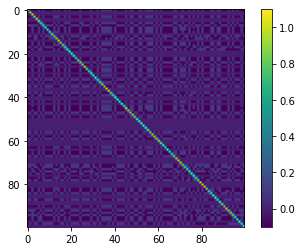

<tf.Variable 'Variable:0' shape=(100, 100) dtype=float64, numpy=
array([[ 8.99999999e-01, -1.00000001e-01, -9.99999929e-02, ...,
        -1.00000001e-01, -9.99999996e-02, -1.00000001e-01],
       [ 4.70217491e-06,  9.99999786e-01,  9.95989890e-08, ...,
        -1.56323583e-07,  2.05174661e-07,  2.59869783e-07],
       [-4.26118424e-08, -2.85767494e-08,  1.00000001e+00, ...,
        -1.28063362e-08,  1.06323276e-08,  2.39749488e-09],
       ...,
       [-5.41412169e-06, -5.25383390e-07,  3.67475210e-09, ...,
         9.99999867e-01,  9.14634148e-09, -2.30703216e-07],
       [-9.99999996e-02,  9.99999957e-02, -9.99999478e-02, ...,
         9.99999861e-02,  9.00000018e-01, -9.99999651e-02],
       [ 5.97325062e-06,  6.31229449e-07, -2.77238358e-08, ...,
         2.82661337e-07, -6.16596673e-08,  1.00000032e+00]])>

In [75]:
plt.imshow(Ctf.numpy())
plt.colorbar()
plt.show()
Ctf